##TurboEssay: AI-Powered Specialized Essay Writerr

**Description:**
TurboEssay is an AI-powered essay writing assistant built using OpenAI’s GPT-4 Turbo. It is designed to generate high-quality, structured essays on various topics with customizable writing styles, tones, and formats. The goal is to enhance the writing experience for students, professionals, and content creators by providing a seamless and efficient way to draft, edit, and refine essays.

**Key Features:**

Topic-Based Essay Generation – Generate well-structured essays based on user-provided topics.
Outline & Content Structuring – Creates logical outlines before drafting full essays.
Grammar & Coherence Enhancement – Ensures readability, flow, and grammatical correctness.

**Tech Stack:**

OpenAI GPT-3.5 Turbo – For natural language generation.
Python / Flask / FastAPI – Backend integration for API calls.
SQLite / PostgreSQL – For saving essay drafts and user preferences.


## Create the virtual Environment

Its always best practice to keep the sepearate environment for each project so that we dont mess with the overall system consifigurations.

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
!pip install virtualenv

In [36]:
!source myenv/bin/activate

In [37]:
!virtualenv myenv

created virtual environment CPython3.11.11.final.0-64 in 620ms
  creator CPython3Posix(dest=/content/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.0.1, setuptools==75.8.2, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


**These below libs are used for ploting the graph**

In [38]:
!apt-get install -y graphviz graphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [39]:
!pip install pygraphviz --no-cache-dir --global-option=build_ext --global-option="-I/usr/include/graphviz" --global-option="-L/usr/lib/graphviz"


DEPRECATION: --build-option and --global-option are deprecated. pip 24.2 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859


In [40]:
!pip install tavily-python
!pip install langgraph-checkpoint-sqlite
!pip install langgraph
!pip install langchain
!pip install langchain openai
!pip install langchain-community
!pip install langchain-openai

In [41]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.base import Checkpoint


In [42]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    print(dir(memory))  # Inspect available attributes and methods


['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'aget', 'aget_tuple', 'alist', 'aput', 'aput_writes', 'config_specs', 'conn', 'cursor', 'from_conn_string', 'get', 'get_next_version', 'get_tuple', 'is_setup', 'jsonplus_serde', 'list', 'lock', 'put', 'put_writes', 'serde', 'setup']


**custom data type called AgentState using the TypedDict feature from the typing module.**

`task: (str)` The original writing prompt or task assigned to the agent. This could be something like "Write an essay about the benefits of exercise".

`plan: (str)` The high-level outline or plan the agent generates for the essay. This would be the structured approach it plans to take.

`draft: (str)` The current version of the essay that the agent has written. This is the actual text of the essay.

`critique: (str)` Feedback or evaluation of the current draft, possibly generated by another component of the system or even a human reviewer.

`content: (List[str])` A list of strings representing additional information or resources relevant to the essay. This could include research findings, supporting arguments, or even counterpoints.

`revision_number: (int)` Keeps track of how many times the essay draft has been revised.

`max_revisions: (int)`The maximum number of revisions allowed before the essay is considered complete.

In [43]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

`model = ChatOpenAI(...)`: This line initializes an instance of the ChatOpenAI class and assigns it to the variable model. This instance will be used to interact with the OpenAI API.

`model="gpt-3.5-turbo"`: This argument specifies that we're using the "gpt-3.5-turbo" model, which is a powerful large language model from OpenAI.

`temperature=0`: This argument sets the temperature parameter to 0. The temperature controls the randomness of the model's output. A temperature of 0 makes the output more deterministic (less random).

`openai_api_key`=OPENAI_API_KEY: This argument passes the previously retrieved OPENAI_API_KEY to authenticate with the OpenAI API.

`streaming=True`: This argument enables streaming responses from the model, allowing you to receive and process the model's output in real-time as it's generated.

In [44]:
from langchain_openai.chat_models import ChatOpenAI
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0,openai_api_key=OPENAI_API_KEY,streaming=True,)

In [45]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [46]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [47]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [48]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [49]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


**Purpose of the Queries Class**
The Queries class serves as a container to store and manage the search queries generated by the AI. This structure is used to organize and pass search queries to the research components of the essay writing system.

**In simpler terms**: Imagine you need to gather information for your essay. You might come up with a few search queries to use on Google, like:

"Benefits of regular exercise"
"Impact of exercise on mental health"
"Types of exercise for beginners"
The Queries class is like a digital list where the AI stores these search terms:

In [50]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [51]:
from tavily import TavilyClient
import os

TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
tavily = TavilyClient(api_key=TAVILY_API_KEY)

In [52]:
#planner Node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [53]:
#research plan node
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [54]:
#generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


In [55]:
#reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [56]:
#research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [57]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [58]:
#build the state grapgh
builder = StateGraph(AgentState)

In [59]:
#add the node's
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [60]:
#set entry point at planner
builder.set_entry_point("planner")

In [61]:
#add the conditional edges
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)


In [62]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [63]:
graph = builder.compile(checkpointer=memory)

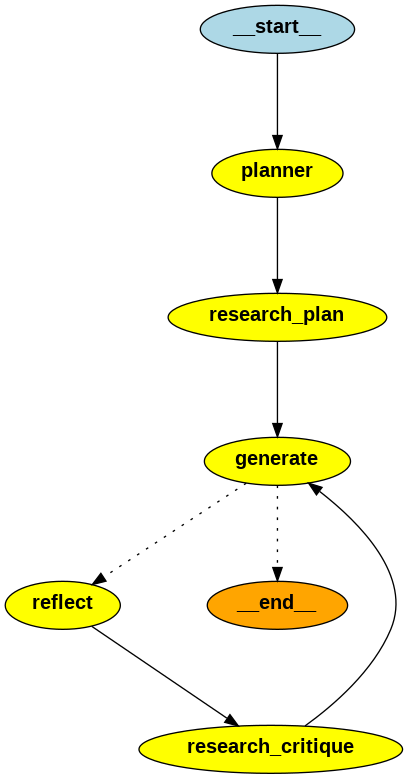

In [64]:
from IPython.display import Image

#display the grapgh
Image(graph.get_graph().draw_png())

In [65]:
from IPython.display import display, JSON
import json

thread = {"configurable": {"thread_id": "1"}}

with SqliteSaver.from_conn_string(":memory:") as memory:
    graph = builder.compile(checkpointer=memory) # Recompile inside the 'with' block
    for s in graph.stream({
            'task': "what is the difference between LangChain and LangSmith?",
            "max_revisions": 2,
            "revision_number": 1,
            "content": [],
        }, thread):
            if s:
                json_data = dict(s)
                print(json.dumps(json_data, indent=2))

{
  "planner": {
    "plan": "I. Introduction\n    A. Brief overview of LangChain and LangSmith\n    B. Thesis statement: Exploring the differences between LangChain and LangSmith\n\nII. LangChain\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. LangSmith\n    A. Definition and purpose\n    B. Key features and functionalities\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between LangChain and LangSmith\n    A. Technology stack\n    B. Scalability and performance\n    C. Security and privacy\n    D. Community and adoption\n    E. Future outlook\n\nV. Conclusion\n    A. Recap of the main differences between LangChain and LangSmith\n    B. Implications for the blockchain industry\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure to provide clear definitions and examples for both LangChain and LangSmith.\n- Use specific examples and

## Conclusion:

TurboEssay aims to revolutionize the way essays are written by leveraging the power of OpenAI’s GPT-3.5 Turbo. With its intelligent structuring, customizable writing , it serves as an invaluable tool for students, researchers, and professionals. By integrating advanced NLP techniques with an intuitive user interface, TurboEssay enhances productivity, creativity, and efficiency in academic and professional writing. As the project evolves, additional features such as styling, adding source for citation, fact-checking, multilingual support, and real-time collaboration can further refine its capabilities, making it a comprehensive AI-powered writing assistant. 🚀